In [1]:
#Importing libraries
from datetime import datetime
import pandas as pd
import numpy as np
import holidays
from haversine import haversine, Unit
from itertools import product

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "notebook"

# 1. Data Exploration

First read the data and do a basic check of missing data, duplicates, data types.

In [2]:
df = pd.read_csv("./data/robotex5.csv")

## 1.1 Data Cleaning

Check for missing data:
- No data is NaN.

In [3]:
df.isna().sum()

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64

Check data types.
- Need to convert `start_time` into datetime object.
- `float64` values can probably be converted to `float32` to reduce impact on memory (see mins/maxes).

In [4]:
df.dtypes

start_time     object
start_lat     float64
start_lng     float64
end_lat       float64
end_lng       float64
ride_value    float64
dtype: object

Examine minimum and maximum values in the dataset:
- The data is distributed in a time window between 01-03-2022 and 28-03-2022.
- The starting coordinates seem to be compatible with the geographical location of Tallinn.
- The extremes of the ending coordinates seem to be very different, probably wrong entries.
- The maximum `ride_value` appears to be quite high.

In [5]:
df.min(axis=0)

start_time    2022-03-01 00:00:07.936317000
start_lat                         59.321557
start_lng                         24.505199
end_lat                          -37.819979
end_lng                         -122.453962
ride_value                         0.107628
dtype: object

In [6]:
df.max(axis=0)

start_time    2022-03-28 23:59:53.175658000
start_lat                         59.566998
start_lng                         24.973743
end_lat                           61.552744
end_lng                           144.96611
ride_value                         3172.701
dtype: object

Check for duplicates:
- There are 4564 duplicated entries, which can be removed.

In [7]:
df.duplicated().value_counts()

False    622646
True       4564
Name: count, dtype: int64

Example of duplicated entries:

In [8]:
df[
    df["start_time"] == df[
            df.duplicated(subset="start_time", keep=False)
    ].reset_index().loc[0, "start_time"]
]

start_time  start_lat  start_lng    end_lat  \
11      2022-03-26 06:22:16.852891000  59.439895  24.754422  59.432426   
231610  2022-03-26 06:22:16.852891000  59.439895  24.754422  59.432426   

          end_lng  ride_value  
11      24.740126     0.28675  
231610  24.740126     0.28675

Collecting all the pre-cleaning and processing steps in a single function, and prepare dataset for further statistical analysis.

In [9]:
def process_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Function to aggregate data cleaning and processing steps. 
    
    Args:
    - df: pd.DataFrame - Data to be processed
    
    Returns:
    - pd.DataFrame - Processed data
    """
    # Remove duplicates
    df = df[~df.duplicated()].reset_index(drop=True)
    # Convert start_time to datetime and sort by it
    df["start_time"] = pd.to_datetime(df["start_time"])
    df = df.sort_values("start_time")
    # Convert float64 columns to float32
    float_cols = df.select_dtypes(include=["float64"]).columns
    df[float_cols] = df[float_cols].astype("float32")
    return df

In [10]:
df = process_data(df)

## 2. Statistical Analysis

Study and visualize the data distribution to understand how the data looks like, if there are outliers, etc.

- As already noticed, by looking at the dataframe description, it looks like a few entries have outlier values in `end_lat`, `end_lng` and probably `ride_value`

In [11]:
df.describe().T

count                           mean  \
start_time    622646  2022-03-15 18:59:21.545893376   
start_lat   622646.0                      59.428684   
start_lng   622646.0                      24.743483   
end_lat     622646.0                      59.397579   
end_lng     622646.0                       24.72468   
ride_value  622646.0                       2.268596   

                                   min                            25%  \
start_time  2022-03-01 00:00:07.936317  2022-03-09 00:03:57.959799552   
start_lat                    59.321556                      59.418812   
start_lng                    24.505199                      24.713154   
end_lat                     -37.819977                      59.415215   
end_lng                    -122.453964                      24.707899   
ride_value                    0.107628                        0.54525   

                                      50%                            75%  \
start_time  2022-03-16 08:22:42.513948160  2022-03-22 21:29:45.173893376   
start_lat                       59.432068                      59.439026   
start_lng                       24.744678                      24.768124   
end_lat                         59.430698                      59.439262   
end_lng                         24.744333                      24.773922   
ride_value                          1.059                          1.712   

                                   max        std  
start_time  2022-03-28 23:59:53.175658        NaN  
start_lat                    59.566998   0.021761  
start_lng                    24.973743    0.05687  
end_lat                      61.552742   1.397846  
end_lng                      144.96611   1.656725  
ride_value                 3172.700928  45.053886

We can look at the data distribution using histograms to confirm that these columns contain outliers values and then clean the dataset.

In [12]:
def plot_all_columns(df:pd.DataFrame):
    """ Function to plot histograms of all columns in a DataFrame.

    Args:
    - df: pd.DataFrame - Data to be plotted
    """
    fig, ax = plt.subplots(2,3, figsize=(16,9))

    for i, c in enumerate(df.columns):
        sns.histplot(df[c], bins=100, ax=ax[i//3, i%3])
        ax[i // 3, i % 3].grid(True, which="both", ls="--", alpha=0.5)

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(
        locator
    )
    ax[0, 0].xaxis.set_major_locator(locator)
    ax[0, 0].xaxis.set_major_formatter(formatter)
    ax[0, 0].xaxis.set_tick_params(rotation=30)

    plt.tight_layout()
    plt.show()

The outlier values are clearly distorting the visualizations of the distributions, so we can confidently remove them. A dedicated study to understand their origin and possibly correct them can be performed as a separate project.

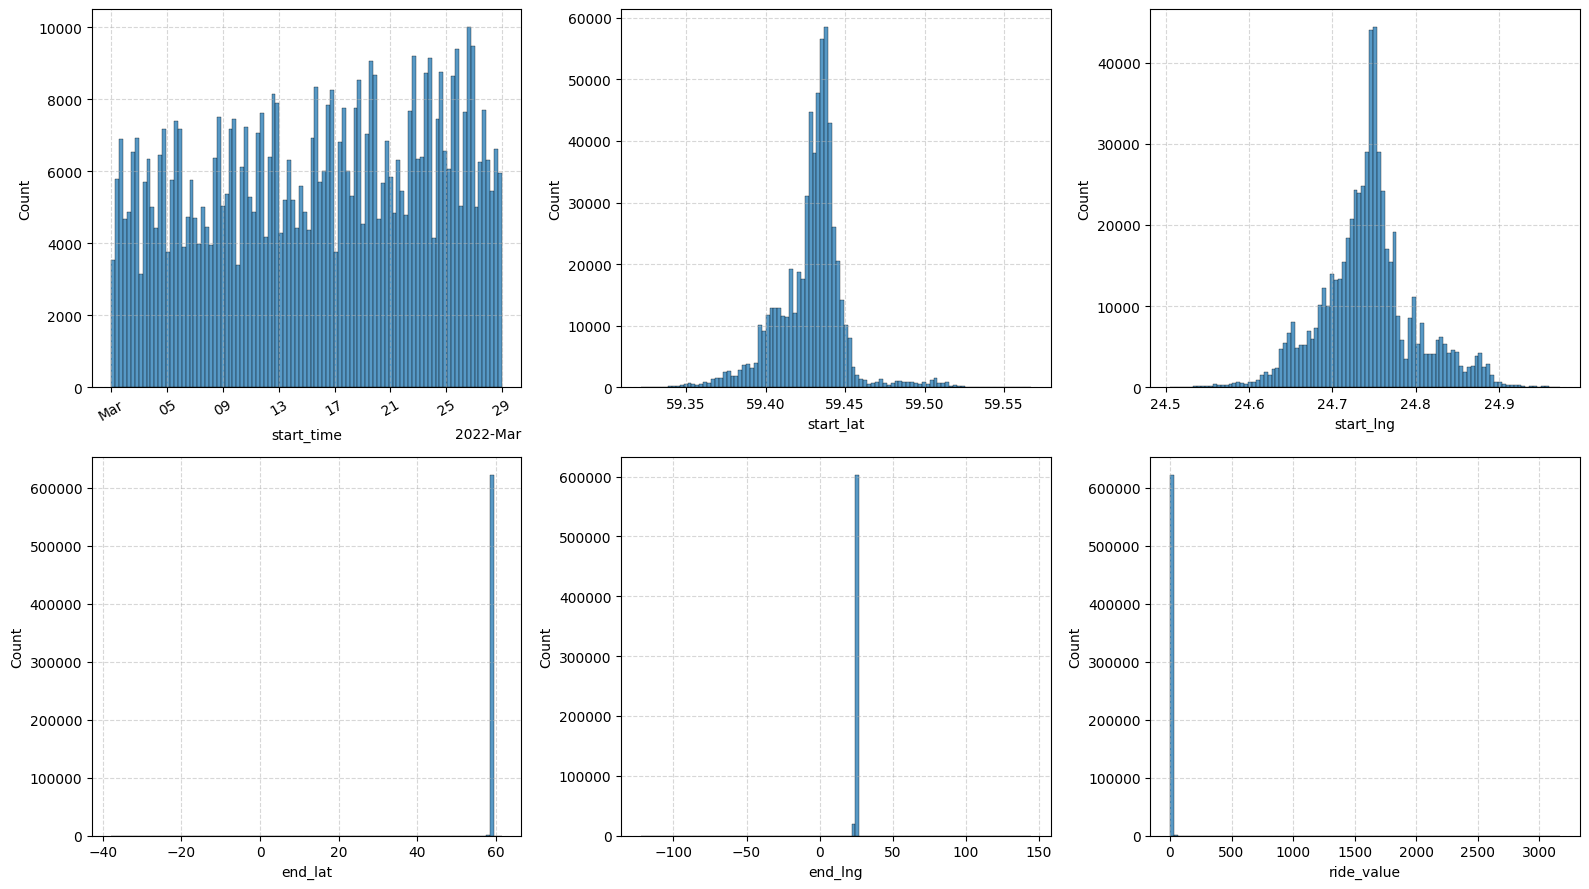

In [13]:
plot_all_columns(df)

A simple data-agnostic method to remove outliers is to select only the data in a window of +/- n * std.dev from the mean of the distribution (also known as sigma-clipping). More specialized methods can be developed if the knowledge around the data distributions is higher, but in this case we will use this simple statistical method.

In [14]:
def remove_outliers(df: pd.DataFrame, columns: list, n: float = 3) -> pd.DataFrame:
    """
    Remove rows from a DataFrame where values in the specified columns
    are more than n standard deviations away from the mean.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names to check for outliers.
    - n (float): Number of standard deviations to consider as the threshold for outliers.

    Returns:
    - pd.DataFrame: A DataFrame with outliers removed.
    """
    original_len = len(df)
    for col in columns:
        if col in df.columns:
            mean = df[col].mean()
            std = df[col].std()
            df = df[np.abs(df[col] - mean) <= (n * std)]
        else:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    print(f"Removed {original_len - len(df)} rows as outliers.")
    return df.reset_index(drop=True)

Selecting n=4 is equivalent to keeping 99.99% of the data, in the approximation of a Normal distribution.

In [15]:
df = remove_outliers(df, df.select_dtypes(include=["float"]).columns, n=5)

Removed 1502 rows as outliers.


The distributions of the different variables now look cleaned and without evident outliers.
- The data spans 4 weeks in the month of March 2022
- The geographical coordinates are all located near the city of Tallinn as expected.
- The `ride_value` has an asymmetrical distribution with a mean of 1.24 and a long right decreasing tail.

In [16]:
df.describe().T

count                           mean  \
start_time    621144  2022-03-15 18:59:28.580602112   
start_lat   621144.0                      59.428616   
start_lng   621144.0                      24.743414   
end_lat     621144.0                      59.427277   
end_lng     621144.0                      24.744402   
ride_value  621144.0                       1.243187   

                                   min                            25%  \
start_time  2022-03-01 00:00:07.936317  2022-03-09 00:04:21.360839936   
start_lat                    59.321556                      59.418789   
start_lng                    24.505199                      24.713135   
end_lat                      59.167839                      59.415371   
end_lng                      24.201582                      24.708084   
ride_value                    0.107628                        0.54425   

                                      50%                            75%  \
start_time  2022-03-16 08:22:53.913679616  2022-03-22 21:28:46.069026048   
start_lat                        59.43206                      59.439007   
start_lng                       24.744642                      24.768042   
end_lat                         59.430729                       59.43927   
end_lng                         24.744347                      24.773912   
ride_value                       1.056249                        1.70625   

                                   max       std  
start_time  2022-03-28 23:59:53.175658       NaN  
start_lat                    59.537418  0.021594  
start_lng                    24.973743  0.056835  
end_lat                      59.566624  0.025908  
end_lng                      25.191174  0.066947  
ride_value                    6.639188  0.903959

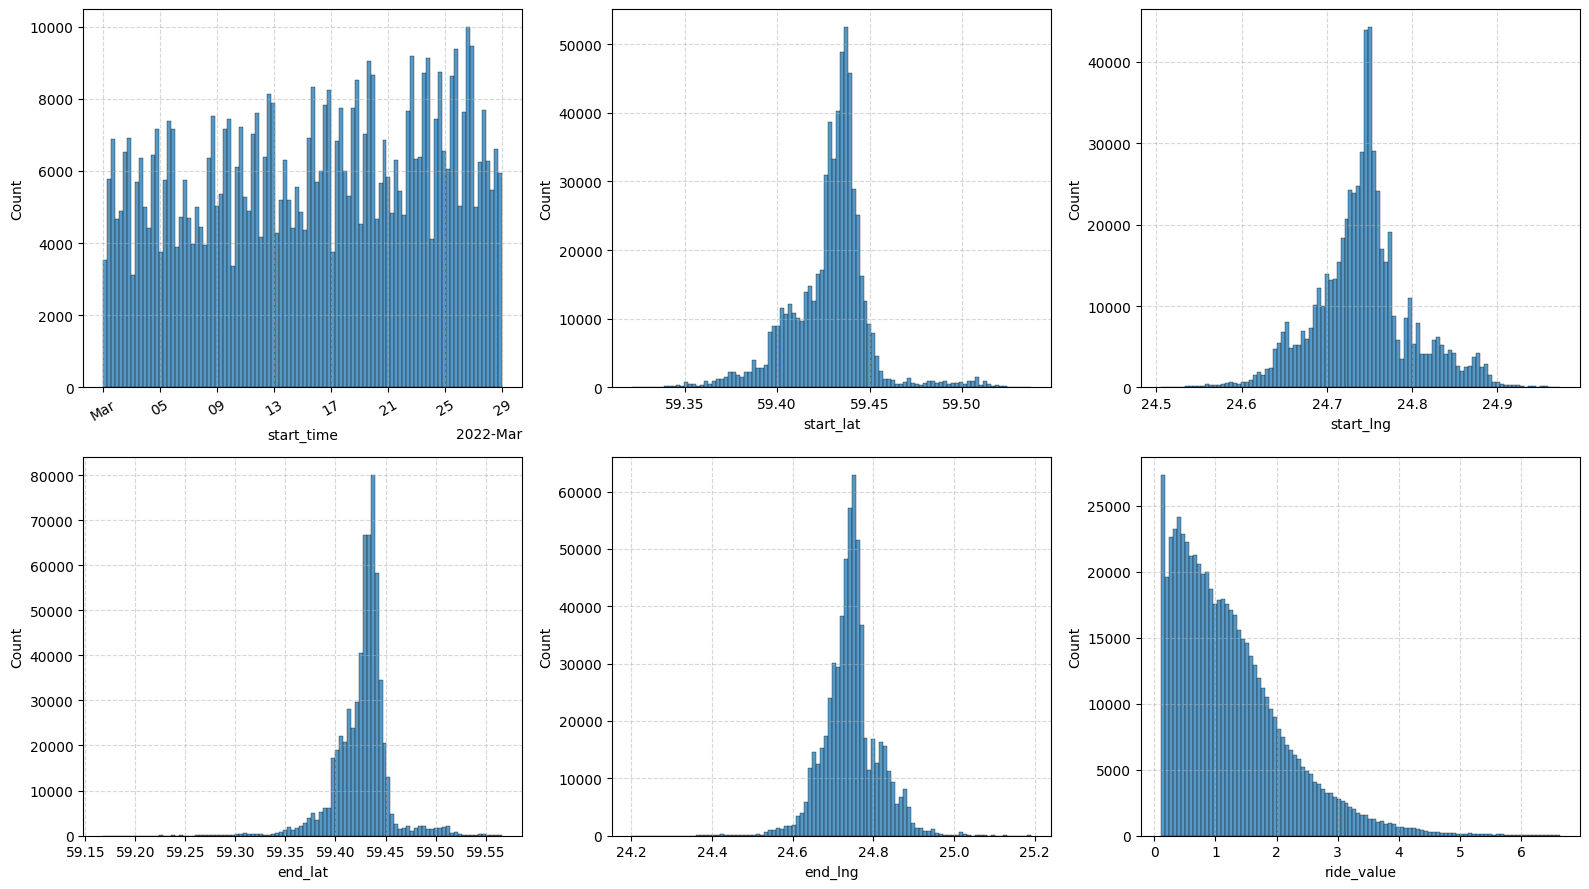

In [17]:
plot_all_columns(df)

# 3. Feature engineering

Generation of additional features to improve the modelling.

## 3.1 Time Features

Use the `start_time` variable to generate useful time features that can be used for modelling. Given that the data spans over a single month, we can make use of variables like `hour`, `minutes` (rounded every 5 minutes), `day_of_week`, `is_weekend` and maybe `is_holiday`.

In [18]:
estonia_holidays = holidays.Estonia(years=df["start_time"].dt.year.unique())
print(
    f"The current dataset contains {df["start_time"].dt.date.isin(estonia_holidays).sum()} estonian holidays."
)

The current dataset contains 0 estonian holidays.


- It is not possible to estimate holidays effects from this dataset.

In [19]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """ Function to add time features to a DataFrame.
    
    Args:
    - df: pd.DataFrame - Data to be processed
    
    Returns:
    - pd.DataFrame - Data with added time features
    """
    # Round minutes to the nearest 5 minutes
    if "rounded_time" not in df.columns:
        df["rounded_time"] = pd.to_datetime(df["start_time"]).dt.floor(
            "5min"
        )
    df["hour"] = df["rounded_time"].dt.hour
    df["minutes"] = df["rounded_time"].dt.minute
    # Monday is 0 and Sunday is 6
    df["day_of_week"] = df["rounded_time"].dt.dayofweek 
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    return df

In [20]:
df = add_time_features(df)

Let's visualize the statistics of the new time variables to understand how well all the cases are covered.
- There is a clear evidence of a daily profile.
- The daily peaks are around 7:00, 16:00 and 22:00. These values correlate with the usual rush hours in a city, and going home at night.
- Saturday is the day of the week with most rides, and Monday the least frequent.
- The minutes seem to be almost uniformly distributed, with a slight increase between 25 and 45, probably to arrive at destination at the hour mark.
- During the weekend there are a few more rides than one can expect from a naive 2/7 ratio.

In [21]:
def countplot_time_features(df: pd.DataFrame, columns: list = ["hour", "minutes", "day_of_week", "is_weekend"]):
    """ Function to plot countplots of time features in a DataFrame.
    
    Args:
    - df: pd.DataFrame - Data to be plotted
    - columns: list - List of columns to plot
    """
    fig, ax = plt.subplots(2, 2, figsize=(9, 6))

    for i, c in enumerate(columns):
        sns.countplot(data=df, x=c, ax=ax[i//2, i%2])
        ax[i // 2, i % 2].set_title(f"{c}")
        ax[i // 2, i % 2].set_xlabel("")
        ax[i // 2, i % 2].set_ylabel("Count")
        ax[i // 2, i % 2].grid(True, which="both", ls="--", alpha=0.5)

        if c == "hour":
            ax[i // 2, i % 2].set_xticks(range(0, 24, 2))

    plt.tight_layout()
    plt.show()

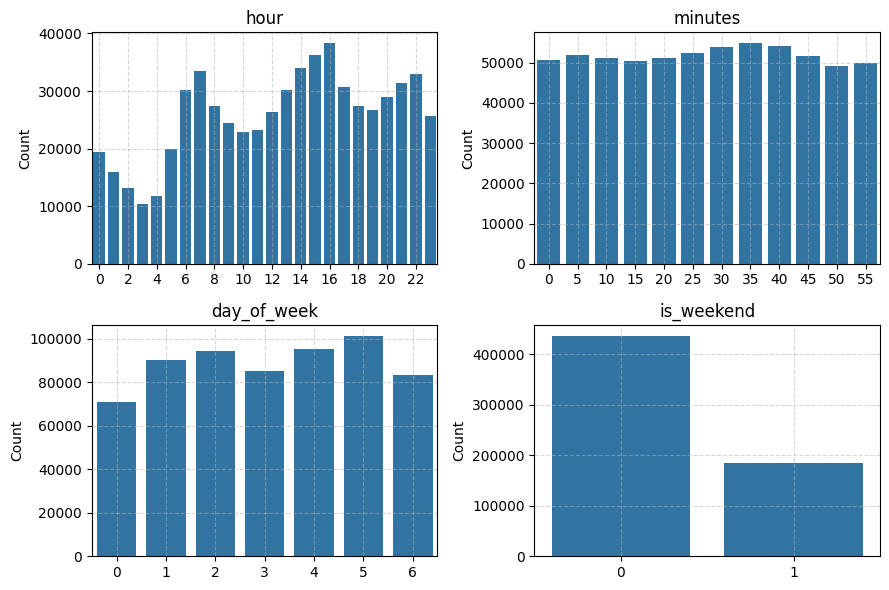

In [22]:
countplot_time_features(df)

We can visualize the hourly profiles of every day of the week, to better understand the differences between them:
- The location of the peaks is uniform over the week.
- The height of peaks is increasing from Monday to Saturday.
- Saturday shows the highest peak during the night.
- Middle of the week days show a slightly less pronounced valley in the daily profile during working hours compared to the rest of the days.

In [50]:
def countplot_week_hours(df: pd.DataFrame):
    """ Function to plot countplots of hours for each day of the week. """
    fig, ax = plt.subplots(1, 7, figsize=(16, 3), sharey=True, sharex=True)

    days_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

    df_days = df.groupby("day_of_week")

    for i, (day, name) in enumerate(days_dict.items()):
        sns.countplot(data=df_days.get_group(day), x="hour", ax=ax[i])
        ax[i].set_title(f"{name}")
        ax[i].set_xticks(range(0, 25, 4))
        ax[i].grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()

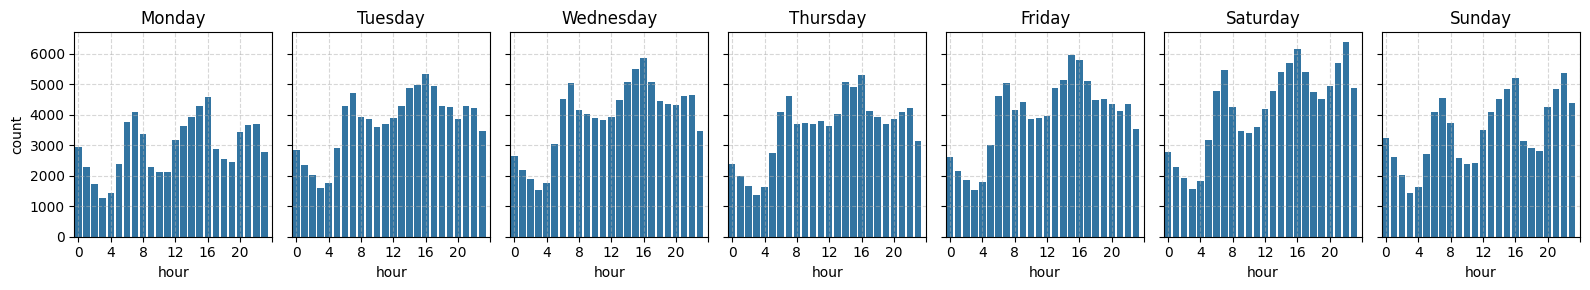

In [51]:
countplot_week_hours(df)

We can explore the distribution of the `ride_value` variable with the new time-related features to investigate possible differences in prices, that might signal a different riders behaviour:
- Differences are not noticeable at this level, all the distributions look very similar.

In [25]:
def violinplot_time_features(df: pd.DataFrame, variable:str, columns: list = ["hour", "minutes", "day_of_week", "is_weekend"], logscale: bool = False):
    """ Function to plot violinplots of time features in a DataFrame.
    
    Args:
    - df: pd.DataFrame - Data to be plotted
    - columns: list - List of columns to plot
    """
    fig, ax = plt.subplots(2, 2, figsize=(9, 6), sharey=True)

    for i, c in enumerate(columns):
        sns.violinplot(
            data=df, x=c, y=variable, ax=ax[i // 2, i % 2], inner="quart", split=True
        )
        ax[i // 2, i % 2].set_title(f"{c}")
        ax[i // 2, i % 2].set_xlabel("")
        ax[i // 2, i % 2].set_ylabel(variable)
        ax[i // 2, i % 2].grid(True, which="both", ls="--", alpha=0.5)

        if c == "hour":
            ax[i // 2, i % 2].set_xticks(range(0, 24, 2))
        
        if logscale:
            ax[i // 2, i % 2].set_yscale("log")

    plt.tight_layout()

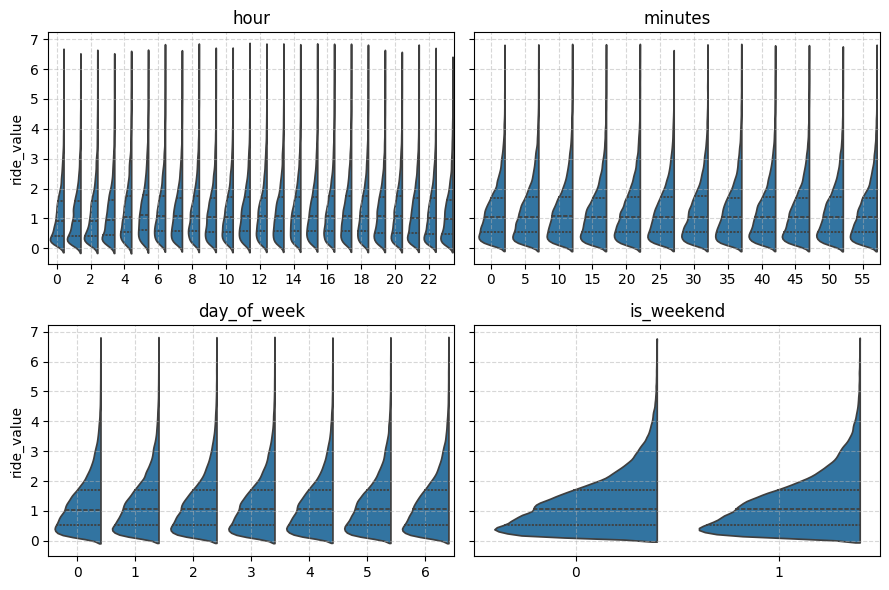

In [26]:
violinplot_time_features(df, "ride_value")

Similarly, we can check for differences in `ride_value` distributions between different days of the week and comparing weekdays vs. weekend.
- All the graphs confirm no relevant differences.

In [27]:
def violinplot_week_hours(df: pd.DataFrame, variable: str):
    """ Function to plot violinplots of hours for each day of the week. 
    
    Args:
    - df: pd.DataFrame - Data to be plotted
    - variable: str - Variable to plot
    """
    fig, ax = plt.subplots(1, 7, figsize=(16, 3), sharey=True, sharex=True)

    days_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

    df_days = df.groupby("day_of_week")

    for i, (day, name) in enumerate(days_dict.items()):
        sns.violinplot(
            data=df_days.get_group(day), x="hour", y=variable, ax=ax[i], inner="quart", split=True
        )
        ax[i].set_title(f"{name}")
        ax[i].set_xticks(range(0, 24, 4))
        ax[i].grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()

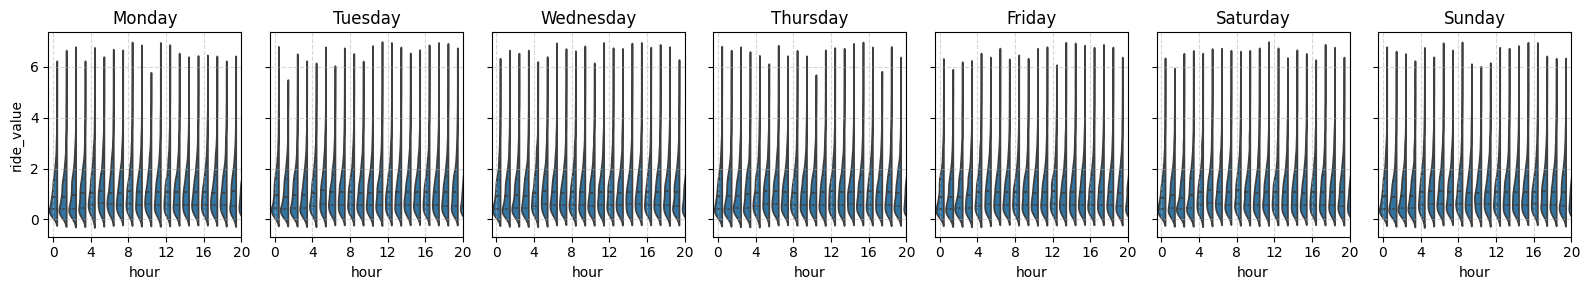

In [28]:
violinplot_week_hours(df, "ride_value")

In [29]:
def violinplot_with_hue(df: pd.DataFrame, variable: str, hue: str):
    """ Function to plot violinplots of a variable with a hue. 
    
    Args:
    - df: pd.DataFrame - Data to be plotted
    - variable: str - Variable to plot
    - hue: str - Hue variable
    """
    fig, ax = plt.subplots(figsize=(9,6))

    sns.violinplot(data=df, x="hour", hue=hue, y=variable, ax=ax, inner="quart", split=True)
    ax.set_xticks(range(0, 24, 4))
    ax.grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()

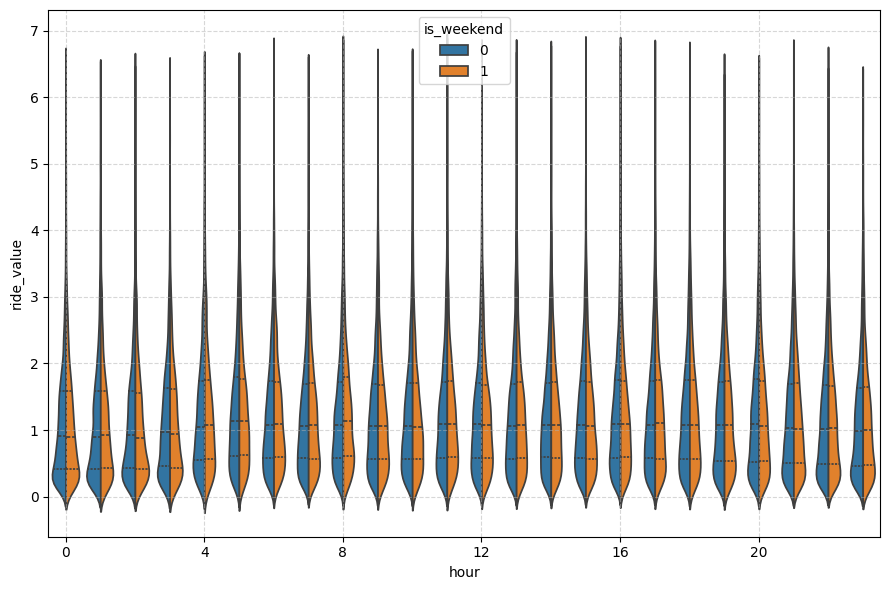

In [30]:
violinplot_with_hue(df, "ride_value", "is_weekend")

## 3.2 Spatial Features

We can use the latitude and logitude variables to generate additional variables that can improve the data analysis and can be included in the modelling.

In [31]:
def calculate_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate great-circle distances for all rows in a DataFrame and add them as a new column.
    Add ratio of ride value to distance as a new column.

    Args:
    - df: pandas DataFrame containing the coordinates.

    Returns:
    - DataFrame with an additional columns for distances (in kilometers) and value_per_km driven.
    """
    def calculate_distance(row):
        origin = (row["start_lat"], row["start_lng"])
        destination = (row["end_lat"], row["end_lng"])
        return haversine(origin, destination, unit=Unit.KILOMETERS)
    df["distance"] = df.apply(calculate_distance, axis=1)
    df["value_per_km"] = df["ride_value"] / df["distance"]
    return df

We calculate distances between start and end locations, for simplicity of calculation we here use great-circle distance. It would be more accurate to calculate driving distance using, e.g. OpenStreetMap or Google Maps APIs, but the time of computation will increase. We can additionally evaluate the `ride_value` per km driven by calculating the ratio between `ride_value` and `distance`.

In [32]:
df = calculate_distance_features(df)

Check the values and the quantiles of the distribution:
- The values are consistent with the previous analysis of the dataset
- The `value_per_km` seems to be centered sharply at 0.25, with a long exponentially decreasing tail on the right. These higher values might be real or aritfacts of the calculations, but are present in very small statistics.
- The shape of the `ride_value` distribution is almost completely driven by the distribution of the driven distances, since the `value_per_km` is almost constant. This means that in the current dataset it will not be possible to extract information about different pricing strategies.

In [33]:
df[["distance", "value_per_km"]].describe().T

count      mean       std       min       25%       50%  \
distance      621144.0  5.030871  3.668379  0.005840  2.203306  4.276751   
value_per_km  621144.0  0.256788  0.188406  0.220669  0.245674  0.246738   

                   75%        max  
distance      6.917645  26.976831  
value_per_km  0.248262  22.711448

We can visualize the new variables to understand their distributions and notice possible correlations with existing time features:
- All the distributions look similar, with no clear time variability.
- Thea peaked shape of the `value_per_km` becomes evident.

[]

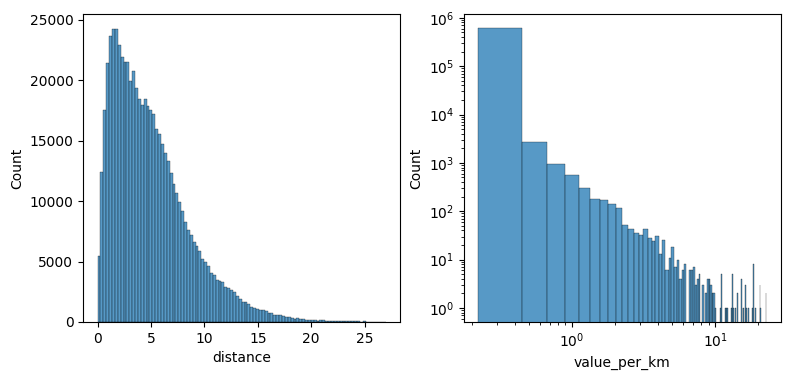

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

sns.histplot(df["distance"], bins=100, ax=ax[0])
sns.histplot(df["value_per_km"], bins=100, ax=ax[1])
ax[1].loglog()

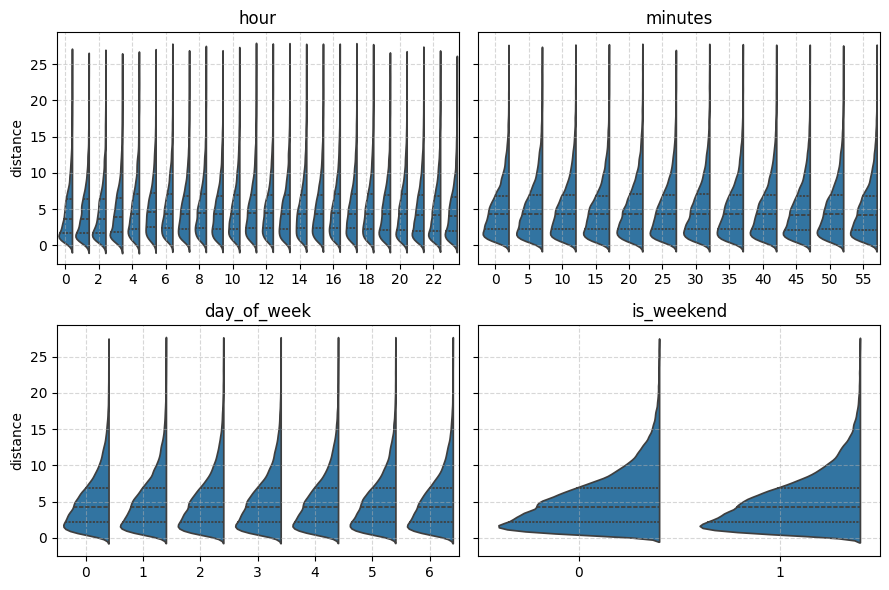

In [35]:
violinplot_time_features(df, "distance")

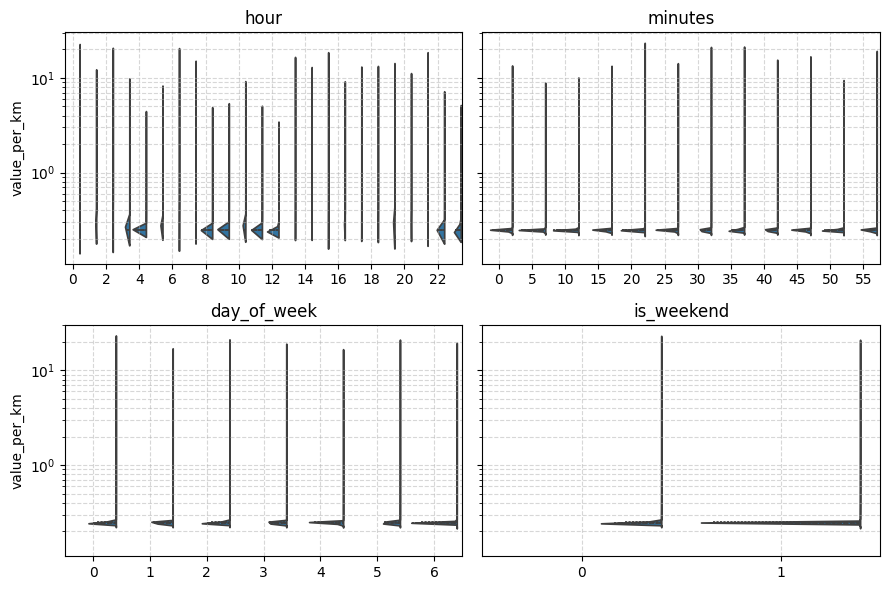

In [36]:
violinplot_time_features(df, "value_per_km", logscale=True)

### 3.2.1 Spatial Clustering
We can cluster geographically the starting and ending coordinates of the dataset. This will allow to perform spatial data aggregation. Here we will use a grid based method over the city of Talling for simplicity. With more resources it would be possible to use other clustering algorithms (k-Means, DBSCAN, etc.). These types of algorithms would provide a more dynamic and data-driven definition of city areas, but the approach will need to be interpreted with a deeper level of insights about the city structure and most likely will need a larger data sample to explain possible correlations.

In [37]:
# Define the bounding box for Tallinn (latitude and longitude range)
lat_min = np.min([df[c].min() for c in ["start_lat", "end_lat"]])
lat_max = np.max([df[c].max() for c in ["start_lat", "end_lat"]])
lng_min = np.min([df[c].min() for c in ["start_lng", "end_lng"]])
lng_max = np.max([df[c].max() for c in ["start_lng", "end_lng"]])

The rectangular grid will be defined with the following boundaries:

In [38]:
print(f"Latitude range: {lat_min} - {lat_max}")
print(f"Longitude range: {lng_min} - {lng_max}")
print(
    f"Dimensions: {haversine((lat_min, lng_min), (lat_min, lng_max), unit=Unit.KILOMETERS):.2f}-lng x "+
    f"{haversine((lat_min, lng_min), (lat_max, lng_min), unit=Unit.KILOMETERS):.2f}-lat km"
)

Latitude range: 59.16783905029297 - 59.56662368774414
Longitude range: 24.201581954956055 - 25.191173553466797
Dimensions: 56.40-lng x 44.34-lat km


In [39]:
# Define grid resolution (n_cells_lat x n_cells_lng total cells)
n_cells_lat = 44
n_cells_lng = 56
lat_bins = np.linspace(lat_min, lat_max, n_cells_lat + 1)
lng_bins = np.linspace(lng_min, lng_max, n_cells_lng + 1)

In [40]:
# Calculate grid cells centers
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
lng_centers = (lng_bins[:-1] + lng_bins[1:]) / 2
grid_centers = list(product(lat_centers, lng_centers))

In [41]:
# Create a mapping of grid IDs to latitude and longitude centers in order to visualize the grid
grid_mapping = []
for i, (clat, clng) in enumerate(grid_centers):
    clat_bin = np.digitize(clat, bins=lat_bins) - 1
    clng_bin = np.digitize(clng, bins=lng_bins) - 1
    grid_id = clat_bin * len(lng_bins) + clng_bin
    grid_mapping.append({"grid_id": grid_id, "lat": clat, "lng": clng})

grid_mapping_df = pd.DataFrame(grid_mapping)

Every starting and ending position is now assigned to a specific cell of a spatial grid. Each cell has an approximate size of ~1km x ~1km. 

In [42]:
# Assign grid IDs
for pre in ["start", "end"]:
    df[f"{pre}_lat_bin"] = np.digitize(df[f"{pre}_lat"], bins=lat_bins) - 1
    df[f"{pre}_lng_bin"] = np.digitize(df[f"{pre}_lng"], bins=lng_bins) - 1
    df[f"{pre}_grid_id"] = df[f"{pre}_lat_bin"] * len(lng_bins) + df[f"{pre}_lng_bin"]

# 4. Data Aggregation

The new spatial and time related features can be used to create an aggregated version of the data that shows supply and demand for each grid cell at each point in time. We will consider time units of 5 minutes. 
- We can assume that each *starting location* corresponds to a passenger looking for a ride (*rider demand*),
- and each *ending location* correspond to an available driver looking for a passenger (*driver supply*).
- Additionally we can estimate an average distance driven per ride, and average value per km driven, and an average ride value per location, per interval of time.

In [43]:
# Group by time and start grid (demand-related metrics)
demand_metrics = (
    df.groupby(["rounded_time", "start_grid_id"])
    .agg(
        demand=("start_grid_id", "size"),
        avg_distance=("distance", "mean"),
        avg_value=("ride_value", "mean"),
        avg_value_per_km=("value_per_km", "mean"),
    )
    .reset_index()
    .rename(columns={"start_grid_id": "grid_id"})
)

In [44]:
# Group by time and end grid (supply-related metrics)
supply_metrics = (
    df.groupby(["rounded_time", "end_grid_id"])
    .agg(supply=("end_grid_id", "size"))
    .reset_index()
    .rename(columns={"end_grid_id": "grid_id"})
)

In [45]:
# Merge demand and supply metrics
overview = pd.merge(
    demand_metrics, supply_metrics, on=["rounded_time", "grid_id"], how="outer"
).fillna(0)

With these newly aggregated values we can calculate additional informations, as 
- Net Demand (demand - supply): an absolute measure of demand-supply balance. Positive values mean that there are riders that cannot be served, negative values mean that there are drivers without rides.
- Demand/Supply Ratio: a relative measure of demand-supply balance. Values larger that 1 mean that that there are riders that cannot be served, values between 0 and 1 mean that there are drivers without rides.

In [ ]:
# Calculate net demand (demand - supply)
overview["net_demand"] = overview["demand"] - overview["supply"]

# Calculate demand/supply ratio
overview["demand_supply_ratio"] = overview["demand"] / (overview["supply"] + 1)

In [47]:
# Ensure numeric columns have appropriate data types
overview[["demand", "supply"]] = overview[["demand", "supply"]].astype(int)
overview["avg_distance"] = overview["avg_distance"].round(2)
overview["avg_value"] = overview["avg_value"].round(2)
overview["avg_value_per_km"] = overview["avg_value_per_km"].round(2)
overview["net_demand"] = overview["net_demand"].astype(int)
overview["demand_supply_ratio"] = overview["demand_supply_ratio"].round(2)

In [48]:
#Sort values by time and grid ID
overview = overview.sort_values(by=["rounded_time", "grid_id"]).reset_index(drop=True)

The new dataframe has the following format:
- `rounded_time`: start of the time interval considered
- `grid_id`: unique id of the spatial grid cell
- `demand`: number of riders
- `supply`: number of drivers
- `avg_distance`: average distance driven per ride
- `avg_value`: average ride value
- `avg_value_per_km`: average value per km driven
- `net_demand`: demand - supply
- `demand_supply_ratio`: demand / (supply + 1)

In [49]:
overview.head()

rounded_time  grid_id  demand  avg_distance  avg_value  avg_value_per_km  \
0   2022-03-01     1106       0          0.00       0.00              0.00   
1   2022-03-01     1179       0          0.00       0.00              0.00   
2   2022-03-01     1279       1          9.31       2.29              0.25   
3   2022-03-01     1337       1          2.96       0.73              0.25   
4   2022-03-01     1397       0          0.00       0.00              0.00   

   supply  net_demand  demand_supply_ratio  
0       1          -1                  0.0  
1       1          -1                  0.0  
2       0           1                  1.0  
3       0           1                  1.0  
4       2          -2                  0.0

## 4.1 Visualizations

We can visualize the new aggregated data on a map and as a timeseries to better understand the demand/supply dynamics of specific zones in the city.

In [52]:
def plot_map(df: pd.DataFrame, variable: str):
    zoom = 9

    fig = px.scatter_mapbox(
        df,
        lat="lat",
        lon="lng",
        size=df[variable].abs(),
        color=variable,
        color_continuous_scale="Spectral_r",
        size_max=15,
        zoom=zoom,
        mapbox_style="carto-positron",
        hover_data={
            "grid_id": True,
            "demand": True,
            "supply": True,
            "avg_distance": True,
            "avg_value": True,
            "lat": False,
            "lng": False,
        },
    )

    # Update layout to customize the colorbar
    fig.update_layout(
        mapbox=dict(center=dict(lat=59.437, lon=24.753), zoom=zoom),
        margin=dict(l=0, r=0, t=0, b=0),
        title=None,
        autosize=False,
        width=600,
        height=400,
        coloraxis_colorbar=dict(
            x=0.85,
            y=0.5,
            len=0.8,
            orientation="v",
            title=dict(
                text=variable,
                side="right",
                font=dict(size=12, weight="bold"),
            ),
        ),
    )

    fig.show()

We can select a specific time step (`specific_time`) and visualize the different variables ovelayed on the city of Tallinn. The circle marks are located at the center of the corresponding grid cells, and their color and size is proportional to the value of the variable in consideration.

In [54]:
# Example: Filter overview DataFrame for a specific time step
specific_time = pd.Timestamp("2022-03-01 08:00")  
filtered_overview = overview[overview["rounded_time"] == specific_time]

# Merge the overview data with grid mapping to get lat/lng for each grid
merged_data = pd.merge(filtered_overview, grid_mapping_df, on="grid_id", how="inner")

Here we look at the demand:

In [55]:
plot_map(merged_data, "demand")

Here we look at the supply and we can already notice that the two maps are different, suggesting a possible unbalance:

In [57]:
plot_map(merged_data, "supply")

The unbalance can be visualized by looking at the `net_demand`

In [58]:
plot_map(merged_data, "net_demand")

Or at the `demand_supply_ratio`. These two variables can evaluate the unbalance from different perspectives.

In [59]:
plot_map(merged_data, "demand_supply_ratio")

We can also visualize the timeseries of supply and demand of a single grid cell, highlighting when there was an excess of demand or supply. For example, we can focus on the first three days of data in the grid cell with ID `selected_id`.
- The top panel shows demand (black) and supply (blue), highlighting in red time windows when riders are in over abundance compared to drivers and in blue when the opposite occours.
- The middle panel shows the Net Demand (`demand` - `supply`).
- The bottom panel shows the Ratio between Demand and Supply.

In [60]:
selected_id = 1683
filtered_zone = overview.groupby("grid_id").get_group(selected_id)
filtered_zone = filtered_zone[filtered_zone["rounded_time"] <= pd.to_datetime("2022-03-03 00:00")]

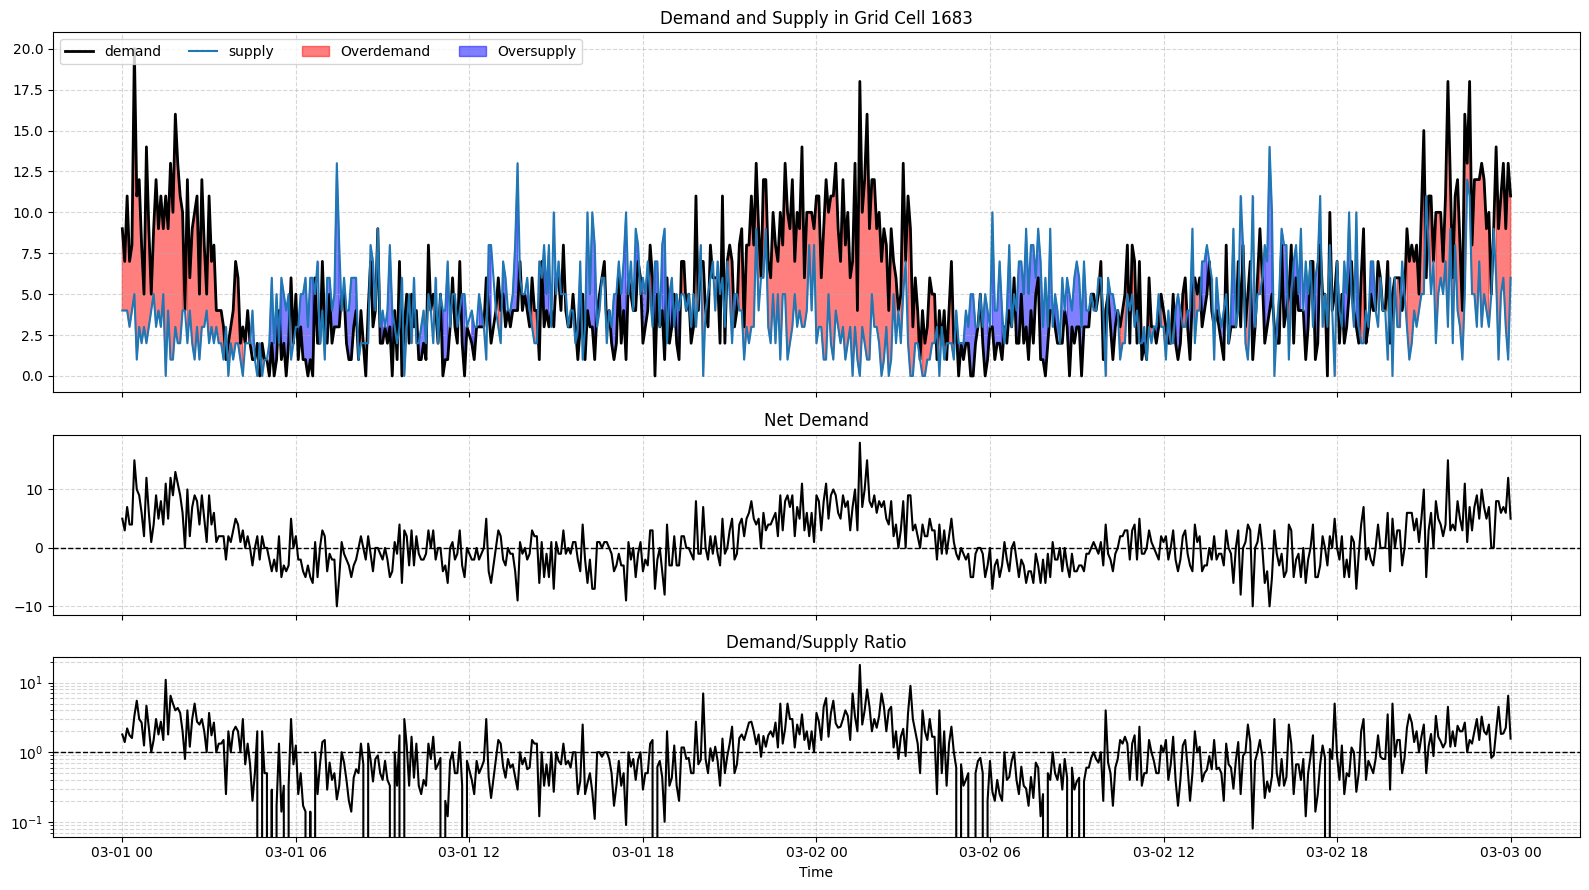

In [79]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), height_ratios=(2,1,1), sharex=True)

sns.lineplot(data=filtered_zone, x="rounded_time", y="demand", ax=ax[0], label="demand", color="black", lw=2)
sns.lineplot(
    data=filtered_zone, x="rounded_time", y="supply", ax=ax[0], label="supply", lw=1.5
)

sns.lineplot(
    data=filtered_zone,
    x="rounded_time",
    y="net_demand",
    ax=ax[1],
    label="net_demand",
    color="black",
    lw=1.5,
)
ax[1].axhline(0, ls="--", color="black", lw=1)

sns.lineplot(
    data=filtered_zone,
    x="rounded_time",
    y="demand_supply_ratio",
    ax=ax[2],
    label="demand_supply_ratio",
    color="black",
    lw=1.5,
)
ax[2].axhline(0, ls="-", color="black", lw=1)
ax[2].axhline(1, ls="--", color="black", lw=1)
ax[2].semilogy()

m = filtered_zone["demand"] > filtered_zone["supply"]
n = filtered_zone["demand"] < filtered_zone["supply"]

ax[0].fill_between(
    filtered_zone["rounded_time"],
    filtered_zone["demand"],
    filtered_zone["supply"],
    where=m,
    color="red",
    alpha=0.5,
    label="Overdemand",
)
ax[0].fill_between(
    filtered_zone["rounded_time"],
    filtered_zone["demand"],
    filtered_zone["supply"],
    where=n,
    color="blue",
    alpha=0.5,
    label="Oversupply",
)

ax[0].legend(ncol=4, loc="upper left")
ax[1].legend().set_visible(False)
ax[2].legend().set_visible(False)
for i in range(0, 3):
    ax[i].grid(True, which="both", ls="--", alpha=0.5)
    ax[i].set_ylabel("")

ax[2].set_xlabel("Time")

ax[0].set_title(f"Demand and Supply in Grid Cell {selected_id}")
ax[1].set_title("Net Demand")
ax[2].set_title("Demand/Supply Ratio")

plt.tight_layout()


## 4.3 Additional Analysis

With this aggregated data we can look for additional insights about the data:

# 5. Modelling

We can now train a machine learning model to predict `net_demand` for each grid cell and time of the week in Tallinn.

In [ ]:
prep_overview = add_time_features(overview).drop(
    columns=[
        "demand",
        "supply",
        "demand_supply_ratio",
        "avg_distance",
        "avg_value",
        "avg_value_per_km",
    ]
)
prep_overview["grid_id"] = prep_overview["grid_id"].astype("category")

In [ ]:
# Select features and target
features = [
    "grid_id",
    "hour",
    "minutes",
    "day_of_week",
    "is_weekend",
]
target = "net_demand"

In [ ]:
# Step 2: Temporal Train-Test Split
# Split data based on time (e.g., last week for testing)
split_point = prep_overview["rounded_time"].max() - pd.Timedelta(days=7)
train_data = prep_overview[prep_overview["rounded_time"] < split_point]
test_data = prep_overview[prep_overview["rounded_time"] < split_point]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [ ]:
# Step 3: Train LightGBM Regressor

# Train a standard regression model for the mean prediction
mean_model = LGBMRegressor(
    objective="regression",
    random_state=42,
)

mean_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",
    callbacks=[log_evaluation(period=50), early_stopping(stopping_rounds=50)],
)

# Initialize models for different quantiles
quantiles = [0.05, 0.95]  # 5th, and 95th percentiles
quantile_models = {}

for q in quantiles:
    print(f"Training LightGBM for quantile: {q}")
    model = LGBMRegressor(
        objective="quantile",
        alpha=q,
        random_state=42,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric="mae",
        callbacks=[log_evaluation(period=50), early_stopping(stopping_rounds=50)],
    )
    quantile_models[q] = model

In [ ]:
# Predict for each quantile
test_data = test_data.copy()
test_data.loc[:, "net_demand_pred_mean"] = mean_model.predict(X_test)
for q in quantiles:
    test_data.loc[:, f"net_demand_pred_{q*100:n}"] = quantile_models[q].predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, test_data["net_demand_pred_mean"].to_numpy())
rmse = np.sqrt(mean_squared_error(y_test, test_data["net_demand_pred_mean"].to_numpy()))

print(f"MAE (Mean Prediction): {mae:.2f}")
print(f"RMSE (Mean Prediction): {rmse:.2f}")

In [ ]:
filtered_zone = test_data.groupby("grid_id").get_group(1683)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

sns.lineplot(data=filtered_zone, x="rounded_time", y="net_demand", ax=ax, label="net_demand", lw=2)
sns.lineplot(
    data=filtered_zone,
    x="rounded_time",
    y="net_demand_pred_mean",
    ax=ax,
    label="net_demand_pred",
    lw=1.5,
)
ax.fill_between(
    filtered_zone["rounded_time"],
    filtered_zone["net_demand_pred_5"],
    filtered_zone["net_demand_pred_95"],
    color="C1",
    alpha=0.5,
    label="Prediction Interval (10th-90th)",
    zorder=2,
)
ax.legend(ncol=3, loc="upper left")


In [ ]:
def predict_net_demand(current_datetime, latitude, longitude, grid_mapping_df, models):
    """
    Predict net demand for a specific datetime and location. If the net demand is negative,
    find the nearest grid cell with positive net demand.

    Parameters:
        - current_datetime: datetime object representing the current timestamp.
        - latitude: Latitude of the location.
        - longitude: Longitude of the location.
        - grid_mapping_df: DataFrame mapping grid IDs to lat/lng centers.
        - models: Dictionary of trained models for different quantiles and mean regression.

    Returns:
        - Result: Dictionary with predicted net demand and location information.
    """
    # Add temporal features for all grid cells
    feature_vectors = pd.DataFrame(
        {
            "grid_id": grid_mapping_df["grid_id"],
            "hour": current_datetime.hour,
            "minutes": current_datetime.minute,
            "day_of_week": current_datetime.weekday(),
            "is_weekend": 1 if current_datetime.weekday() >= 5 else 0,
        }
    )

    # Ensure grid_id is treated as a categorical variable
    feature_vectors["grid_id"] = feature_vectors["grid_id"].astype("category")

    # Predict net demand for all grid IDs
    mean_predictions = models["mean"].predict(feature_vectors)
    lower_predictions = models["quantile_10"].predict(feature_vectors)
    upper_predictions = models["quantile_90"].predict(feature_vectors)

    # Add predictions to the grid mapping DataFrame
    grid_mapping_df["predicted_net_demand"] = mean_predictions
    grid_mapping_df["lower_bound"] = lower_predictions
    grid_mapping_df["upper_bound"] = upper_predictions

    # Find the closest grid cell for the input location
    grid_mapping_df["distance"] = grid_mapping_df.apply(
        lambda row: haversine(
            (latitude, longitude), (row["lat"], row["lng"]), unit=Unit.KILOMETERS
        ),
        axis=1,
    )
    closest_grid = grid_mapping_df.loc[grid_mapping_df["distance"].idxmin()]
    grid_id = closest_grid["grid_id"]

    # Extract prediction for the closest grid cell
    mean_pred = closest_grid["predicted_net_demand"]
    lower_bound = closest_grid["lower_bound"]
    upper_bound = closest_grid["upper_bound"]

    result = {
        "latitude": latitude,
        "longitude": longitude,
        "grid_id": grid_id,
        "predicted_net_demand": mean_pred,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
    }

    # If net demand is negative, find the nearest grid cell with positive net demand
    if mean_pred < 0:
        positive_demand_cells = grid_mapping_df[
            grid_mapping_df["predicted_net_demand"] > 0
        ]
        if not positive_demand_cells.empty:
            nearest_positive_cell = positive_demand_cells.loc[
                positive_demand_cells["distance"].idxmin()
            ]
            result["recommendation"] = {
                "recommended_lat": nearest_positive_cell["lat"],
                "recommended_lng": nearest_positive_cell["lng"],
                "recommended_grid_id": nearest_positive_cell["grid_id"],
                "distance_km": nearest_positive_cell["distance"],
            }
        else:
            result["recommendation"] = "No positive net demand cells found."

    return result

In [ ]:
def generate_driver_instructions(result):
    """
    Generate a human-readable text with instructions for the driver based on net demand prediction.

    Parameters:
        - result: Dictionary containing net demand prediction, bounds, and recommendations.

    Returns:
        - instruction: String with instructions for the driver.
    """
    # Extract relevant information from the result dictionary
    latitude = result["latitude"]
    longitude = result["longitude"]
    grid_id = result["grid_id"]
    predicted_net_demand = result["predicted_net_demand"]
    lower_bound = result["lower_bound"]
    upper_bound = result["upper_bound"]
    recommendation = result.get("recommendation")

    # Base message
    instruction = f"Current location: Grid ID {grid_id:n} (lat: {latitude:.5f}, lng: {longitude:.5f}).\n"
    instruction += f"Predicted net demand: {predicted_net_demand:.1f} (range: {lower_bound:.1f} to {upper_bound:.1f}).\n"

    # If net demand is positive
    if predicted_net_demand > 0:
        instruction += "Stay in this location to take advantage of the positive demand.\n"
    else:
        # If net demand is negative and there's a recommendation
        if recommendation:
            recommended_lat = recommendation["recommended_lat"]
            recommended_lng = recommendation["recommended_lng"]
            recommended_grid_id = recommendation["recommended_grid_id"]
            distance_km = recommendation["distance_km"]
            instruction += (
                f"The net demand here is negative.\n"
                f"Move to the nearby grid ID {recommended_grid_id:n} "
                f"(lat: {recommended_lat:.5f}, lng: {recommended_lng:.5f}) which is {distance_km:.2f} km away, "
                "to find a positive demand zone.\n"
            )
        else:
            # No positive net demand cells found
            instruction += "The net demand here is negative, and no nearby grid has positive demand at this time.\n"

    return instruction

In [ ]:
# Example current time and location
current_datetime = datetime(2024, 11, 25, 6, 30)  # Example current time
latitude = 59.435207  # Example latitude
longitude = 24.740555  # Example longitude

# Trained models dictionary (assumes you trained mean, quantile_10, and quantile_90 models)
models = {
    "mean": mean_model,
    "quantile_10": quantile_models[0.05],
    "quantile_90": quantile_models[0.95],
}

# Call the function
result = predict_net_demand(
    current_datetime=current_datetime,
    latitude=latitude,
    longitude=longitude,
    grid_mapping_df=grid_mapping_df,
    models=models,
)

In [ ]:
print(generate_driver_instructions(result))